# ORIE 5355/INFO 5370 HW 1: Survey Weighting

 - Name: Saketh Pabolu
 - Net-id: smp382
 - Date: Sept 14, 2025
 - Late days used for this assignment: N/A
 - Total late days used (counting this assignment): N/A
 - People with whom you discussed this assignment: N/A

After you finish the homework, please complete the following (short, anonymous) post-homework survey: https://forms.gle/CdpUFN582d15kZSH9


We have marked questions in <font color='green'> green </font>. Please put answers in the default color. You'll want to write text answers in "markdown" mode instead of code. In Jupyter notebook, you can go to Cell > Cell Type > Markdown, from the menu. Please carefully read the late days policy and grading procedure [here](https://orie5355.github.io/Fall_2025/assignments/). In that link, we also give some tips on exporting your notebook to PDF, which is required for GradeScope submission. 

A few notes about this homework:
1. This homework is purposefully heavy in using the Pandas package. Being able to explore data is an essential data science skill that you'll use throughout this class and your career -- even if the polling/politics application is not interesting to you. I encourage you to practice Pandas and learn how to use it well. Your code will NOT be graded on efficiency.
2. Some of the questions can be interpreted in multiple ways. That is always true in data science. You'll need to make judgment calls for what analysis to do. For the homework, you'll still receive full points for any "reasonable" choice. Also feel free to ask questions on EdStem. 

Note: We sometimes provide sample images of what your output should look like. These are for clarification of what we are looking for. The numbers in the images are not necessarily correct, and your output does not need to look exactly like the images.

# Conceptual component

### 1) Reading

<font color='green'> Please read Sections 3 and 4 (pages 6-13) here: https://www.nber.org/system/files/working_papers/w20830/w20830.pdf, and answer the following questions.

<font color='green'> Please summarize the sections in no more than two sentences. 

On eBay, seller ratings look almost perfect, but that’s misleading because many unhappy buyers don’t leave feedback. By factoring in silent transactions, the paper's authors create a truer quality measure that shows bigger differences between good and bad sellers.

<font color='green'> Do you think it's a problem that most ratings are positive? If so, why? Answer in no more than four sentences. Please incorporate concepts discussed in class in your answer. 

Ratings inflation makes feedback misleading and hard to trust. For example, on eBay, a seller with 98% positive reviews might actually be among the worst performers, but they still look great on paper. This happens because many of us hold back from leaving negative reviews, whether we are worried about retaliation, do not want to hurt someone’s livelihood, or feel pressured to be nice. The problem is that these inflated scores stop reflecting true quality, so you and I cannot really use them to make informed decisions.

### 2) Personal reflection

<font color='green'> Think back to a time that you trained a model on data from people or gathered opinions via a survey (an informal one is fine). If you have not done that before, you may answer these questions about an article in the news that reported on public opinions or a model that you think might be in deployment at a company or organization with which you interact (for example, Amazon, google maps, etc)

<font color='green'> Briefly summarize the scenario in no more than two sentences. 

I came across a report about YouTube’s algorithm taking action to demonetize videos with AI-generated content. According to the report, YouTube’s model identifies videos created using AI and adjusts their ranking in users’ feeds to promote organically created content instead.

<font color='green'> What was the construct that you cared about/wanted to measure? What was the measurement (numerical data)? In what ways did the measurement not match the construct you cared about? Answer in no more than 4 sentences.  

The construct measured here is the authenticity of the video. The measurement used was the percentage of videos from a creator's channel flagged by Youtube's model. The measurement did not perform well because AI-generated content does not always equate to a lack of authenticity. In some cases, AI tools may support creative expression without undermining originality.

<font color='green'> What selection biases/differential non-response issues occurred and how did it affect your measurement? (If your answer is "None," explain exactly why you believe the assumptions discussed in class were met). Answer in no more than 3 sentences. 

A selection bias might might have occured because only videos detectable by YouTube’s model were included, excluding AI-generated content that slipped through undetected. This showed there was a differential non-response since some AI-generated videos were able to slip through the model's classification and therefore "invisible" to the measurement. As a result, the data underestimated the true prevalence of AI-generated content.

<font color='green'> Given what we have learned in class so far, what would you do differently if faced with the same scenario again? Answer in no more than 3 sentences. 

If I were in the engineer's place, I would improve my sample (training dataset) to include statification or weighting techniques to better align my sample to the target population. I would also be more deliberate about how my measurement connects to the construct, ensuring validity from the start. However, I am not sure how I would approach it in practice because AI-generated videos are a new trend and sometimes it is hard to label datasets identifying AI from real videos.

# Programming component

<font color='green'> In this part of the homework, we provide you with data from a poll in Florida before the 2016 Presidential election in the United States. We also provide you with (one pollster's) estimates of who will vote in the 2016 election, made before the election. You will use this data and apply the weighting techniques covered in class.

## Preliminaries to load packages and data

In [1]:
import pandas as pd
import numpy as np

In [2]:
dfpoll = pd.read_csv('polling_data_hw1.csv') # raw polling data
dfpoll.head()

,candidate,age,gender,party,race,education
0,Someone else,30-44,Male,Independent,White,College
1,Hillary Clinton,45-64,Male,Republican,Hispanic,College
2,Hillary Clinton,30-44,Male,Independent,Hispanic,College
3,Hillary Clinton,65+,Female,Democrat,White,College
4,Donald Trump,65+,Female,Republican,White,High School


In [3]:
dfdemographic = pd.read_csv('florida_proportions_hw1.csv') # proportions of population
dfdemographic.head()

,Electoral_Proportion,Demographic_Type_1,Demographic_Type_2,Demographic_1,Demographic_2
0,0.388,party,NaN,Democrat,NaN
1,0.399,party,NaN,Republican,NaN
2,0.213,party,NaN,Independent,NaN
3,0.446,gender,NaN,Male,NaN
4,0.554,gender,NaN,Female,NaN


In [4]:
dfdemographic.tail()

,Electoral_Proportion,Demographic_Type_1,Demographic_Type_2,Demographic_1,Demographic_2
112,0.034,race,education,Hispanic,Some College
113,0.028,race,education,Hispanic,College
114,0.011,race,education,Other,High School
115,0.011,race,education,Other,Some College
116,0.015,race,education,Other,College


`dfdemographic` contains estimates of likely voters in Florida in 2016. When `Demographic_Type_2` is `NaN`, the row refers to just the marginal population percentage of the group in `Demographic_1` of type `Demographic_Type_1`. When it is not `NaN`, the row has the joint distribution of the corresponding demographic groups.

For example, row 0 means that 38.8% of the electorate is from the Democrat party. Row 113 means that 2.8% of the electorate is Hispanic AND graduated college. 

## Part A: Raw visualization

<font color='green'> Here, we'll visualize whether the respondents in the poll match the likely voter estimates. Create a scatter-plot where each point represents one Demographic group (for example, people who identify as Independet: party-Independent), where the X axis is the `Electoral_Proportion` in `dfdemographic`, and the Y axis is the proportion in `dfpoll` (Hint: you will need to calculate this yourself). 

In [5]:
for col in ["Demographic_Type_1","Demographic_Type_2","Demographic_1","Demographic_2"]:
    dfdemographic[col] = dfdemographic[col].astype(str)

poll_props = []
temp = pd.DataFrame()

for col in ["party", "gender", "age", "race", "education"]:
    temp = dfpoll[col].value_counts(normalize=True).reset_index()
    temp.columns = ["Demographic_1", "poll_proportion"]
    temp["Demographic_Type_1"] = col
    temp["Demographic_Type_2"] = "nan"
    temp["Demographic_2"] = "nan"
    poll_props.append(temp)

temp.head()

,Demographic_1,poll_proportion,Demographic_Type_1,Demographic_Type_2,Demographic_2
0,College,0.435986,education,nan,nan
1,Some College,0.352941,education,nan,nan
2,High School,0.197232,education,nan,nan
3,Refused,0.013841,education,nan,nan


In [6]:
def joint_props(col1, col2):
    temp = dfpoll.groupby([col1, col2]).size() / len(dfpoll)
    temp = temp.reset_index(name="poll_proportion")
    temp = temp.rename(columns={col1: "Demographic_1", col2: "Demographic_2"})
    temp["Demographic_Type_1"] = col1
    temp["Demographic_Type_2"] = col2
    return temp

In [7]:
joint_types = dfdemographic[dfdemographic["Demographic_Type_2"]!="nan"][["Demographic_Type_1","Demographic_Type_2"]].drop_duplicates()
for _, row in joint_types.iterrows():
    poll_props.append(joint_props(row["Demographic_Type_1"], row["Demographic_Type_2"]))
    
dfpoll_props = pd.concat(poll_props, ignore_index=True)

merged = dfdemographic.merge(
    dfpoll_props,
    on=["Demographic_Type_1","Demographic_Type_2","Demographic_1","Demographic_2"],
    how="left"
)

merged.head()

,Electoral_Proportion,Demographic_Type_1,Demographic_Type_2,Demographic_1,Demographic_2,poll_proportion
0,0.388,party,nan,Democrat,nan,0.358708
1,0.399,party,nan,Republican,nan,0.272203
2,0.213,party,nan,Independent,nan,0.348328
3,0.446,gender,nan,Male,nan,0.491349
4,0.554,gender,nan,Female,nan,0.508651


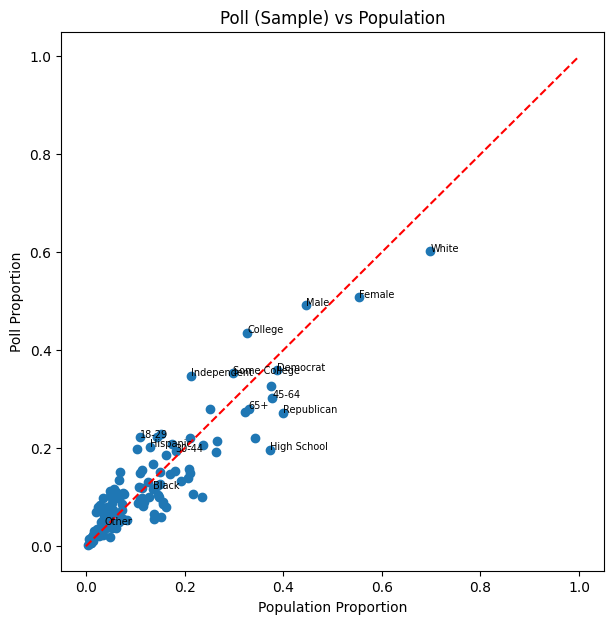

In [8]:
import matplotlib.pyplot as plt

plt.figure(figsize=(7,7))
plt.scatter(merged["Electoral_Proportion"], merged["poll_proportion"])
plt.plot([0,1], [0,1], "r--")

marginals = merged[merged["Demographic_Type_2"] == "nan"]
for _, row in marginals.iterrows():
    plt.text(row["Electoral_Proportion"], row["poll_proportion"], row["Demographic_1"], fontsize=7)

plt.xlabel("Population Proportion")
plt.ylabel("Poll Proportion")
plt.title("Poll (Sample) vs Population")
plt.show()

<font color='green'> `dfdemographic` tells us the true proportion of each demographic group in the entire population, the calculated proportion from dfpoll tells us the proportion of each demographic group represented in the poll. For a poll to be representative of the population, ideally we would want the latter to be the same as the former. However, this is hard to achieve in practice.


In your view, which group is most over-represented? Most under-represented? Why? Answer in no more than 3 sentences. There are multiple reasonable definitions of "over" or "under" represented; any choice is fine as long as you justify your answer.</font>

In [9]:
merged["diff"] = merged["poll_proportion"] - merged["Electoral_Proportion"]

over = merged.loc[merged["diff"].idxmax()][["Demographic_Type_1", "Demographic_1", "diff"]]
under = merged.loc[merged["diff"].idxmin()][["Demographic_Type_1", "Demographic_1", "diff"]]

over, under

(Demographic_Type_1          party
 Demographic_1         Independent
 diff                     0.135328
 Name: 2, dtype: object,
 Demographic_Type_1      education
 Demographic_1         High School
 diff                    -0.176768
 Name: 13, dtype: object)

From the table, we can see that the most over-represented group is the __Independents__, whereas the least represented group is those with a __High School__ education.

## Part B: Weighting

<font color='green'> For this question, we'll ignore people who answered anything but "Hillary Clinton" or "Donald Trump."


You'll notice that some of the groups in the polling data ("refused") do not show up in the population percentages. For the questions that require weighting by demographics, ignore those respondents.



In [10]:
dfvote = dfpoll[dfpoll["candidate"].isin(["Hillary Clinton","Donald Trump"])]

dfvote.groupby("candidate").size()

candidate
Donald Trump       327
Hillary Clinton    393
dtype: int64

### 1) Raw average

<font color='green'> Below, report the "raw polling average," the percentage of people "Hillary Clinton" divided by the number who answered either Hillary or Trump.

In [11]:
raw_counts = dfvote["candidate"].value_counts(normalize=True)
clinton_raw = raw_counts["Hillary Clinton"]
trump_raw = raw_counts["Donald Trump"]

print("Raw Polling Average for Clinton:", round(clinton_raw,3) * 100, "%",
      "Trump:", round(trump_raw,3) * 100, "%")


Raw Polling Average for Clinton: 54.6 % Trump: 45.4 %


### 2) Single dimensional marginal weighting (on just 1 demographic type)

In [12]:
pop_gender = dfdemographic[dfdemographic["Demographic_Type_1"]=="gender"]
pop_gender = pop_gender[pop_gender["Demographic_Type_2"]=="nan"]
pop_gender = dict(zip(pop_gender["Demographic_1"], pop_gender["Electoral_Proportion"]))


poll_gender_counts = dfvote.groupby(["gender", "candidate"]).size()
gender_totals = dfvote.groupby("gender").size()
poll_gender = (poll_gender_counts / gender_totals).reset_index(name="prop")

poll_gender["weight"] = poll_gender["gender"].map(pop_gender)
poll_gender["weighted_prop"] = poll_gender["prop"] * poll_gender["weight"]

result_gender = poll_gender.groupby("candidate")["weighted_prop"].sum().round(4)
print("Weighted by gender:\n", result_gender)


Weighted by gender:
 candidate
Donald Trump       0.4502
Hillary Clinton    0.5498
Name: weighted_prop, dtype: float64


<font color='green'> For each demographic type separately -- age, gender, party, race, and education -- weight the poll by just that demographic type, in accordance to the population proportions given. Report the resulting poll results, and briefly (at most 3 sentences) describe what you observe.


For example, when weighted by race, you'll report:

Weighted by race --- Clinton: 0.531, Trump: 0.469

(your results might be different due to rounding/precision, but we do not expect the difference to be large)


In [13]:
for demographic in ["age", "party", "race", "education"]:
    pop_demo = dfdemographic[
    (dfdemographic["Demographic_Type_1"] == demographic) &
    (dfdemographic["Demographic_Type_2"] == "nan")
    ]
    pop_demo = dict(zip(pop_demo["Demographic_1"], pop_demo["Electoral_Proportion"]))

    poll_demo = dfvote.groupby([demographic, "candidate"]).size() / dfvote.groupby(demographic).size()
    poll_demo = poll_demo.reset_index(name="prop")

    poll_demo["weight"] = poll_demo[demographic].map(pop_demo)
    poll_demo["weighted_prop"] = poll_demo["prop"] * poll_demo["weight"]
    result = poll_demo.groupby("candidate")["weighted_prop"].sum().round(4)

    print(f"Weighted by {demographic}:")
    print(result.round(6), "\n")

Weighted by age:
candidate
Donald Trump       0.4694
Hillary Clinton    0.5306
Name: weighted_prop, dtype: float64 

Weighted by party:
candidate
Donald Trump       0.5013
Hillary Clinton    0.4987
Name: weighted_prop, dtype: float64 

Weighted by race:
candidate
Donald Trump       0.4697
Hillary Clinton    0.5313
Name: weighted_prop, dtype: float64 

Weighted by education:
candidate
Donald Trump       0.4559
Hillary Clinton    0.5441
Name: weighted_prop, dtype: float64 



### 2-dimensional joint distribution weighting

<font color='green'>Now, for each pair of demographic types in dfdemographic, do the same -- weight the poll by that pair of demographic types, in accordance to the given joint distributions, and briefly (at most 3 sentences) describe what you observe.

For example, when weighted by race and age, you'll find:

Weighted by age and race: Clinton: 0.523, Trump: 0.477

In [14]:
def weight_by_two(d1, d2):
    pop = dfdemographic[
        (dfdemographic["Demographic_Type_1"] == d1) &
        (dfdemographic["Demographic_Type_2"] == d2)
    ]
    pop_dict = dict(zip(zip(pop["Demographic_1"], pop["Demographic_2"]), pop["Electoral_Proportion"]))
    
    poll_joint = dfvote.groupby([d1, d2, "candidate"]).size() / dfvote.groupby([d1, d2]).size()
    poll_joint = poll_joint.reset_index(name="prop")
    
    poll_joint["weight"] = poll_joint.apply(lambda r: pop_dict.get((r[d1], r[d2]), 0), axis=1)
    poll_joint["weighted_prop"] = poll_joint["prop"] * poll_joint["weight"]
    
    result = poll_joint.groupby("candidate")["weighted_prop"].sum()
    print(f"\nWeighted by {d1} + {d2}:")
    print(result.round(6))

weight_by_two("age", "race")
weight_by_two("age", "education")
weight_by_two("race", "education")
weight_by_two("race", "gender")
weight_by_two("party", "gender")


Weighted by age + race:
candidate
Donald Trump       0.475569
Hillary Clinton    0.523431
Name: weighted_prop, dtype: float64

Weighted by age + education:
candidate
Donald Trump       0.473932
Hillary Clinton    0.525068
Name: weighted_prop, dtype: float64

Weighted by race + education:
candidate
Donald Trump       0.48592
Hillary Clinton    0.51508
Name: weighted_prop, dtype: float64

Weighted by race + gender:
candidate
Donald Trump       0.0
Hillary Clinton    0.0
Name: weighted_prop, dtype: float64

Weighted by party + gender:
candidate
Donald Trump       0.497153
Hillary Clinton    0.502847
Name: weighted_prop, dtype: float64


Weighting by `age+race`, `age+education`, and `race+education` all give results around 52–53% Clinton vs. 47–48% Trump which is consistent with the dataset's overall pro-Clinton lean. Weighting by `party+gender` pulls the results much closer around a nearly a 50–50 split, which shows the strong importance of partisan balance. The `race+gender` weighting showed a 0, I think it suggests missing or mismatched categories in the population table for that combination, so it doesn’t result a meaningful estimate.

<font color='green'>We don't always have access to joint distributions across the population -- for example, it may be hard to estimate from past exit polls (surveys done as people are leaving the polling station) what the joint distribution of education and gender is, for example. However, access to marginal distributions are often available. 

As discussed in class, one strategy when you don't have access to joint distributions -- only marginals -- is to _multiply_ the marginal distributions. For example, if 50% of your population is Democratic and 50% is a woman, then pretend that 50% times 50% = 25% of your population is a Democratic women. Clearly this technique is not perfect, but it is sometimes a useful heuristic. (Hint: you can use the marginal distribution provided in dfdemographic)

For the following pairs of Demographic types, report the weighting results if you use the joint distributions in dfdemographic versus if you approximate the joint distribution using the marginals. Briefly (at most 3 sentences) describe what you observe.

(party, gender)

(race, gender)

As an example output, here's the results for two other pairs of demographics (your results might be different due to rounding, but we do not expect the difference to be large):

| Demo1   | Demo2     |    Joint |   Marginal |
|:--------|:----------|---------:|-----------:|
| age     | race      | 0.523431 |   0.525669 | 
| age     | education | 0.525068 |   0.523938 |  

In [15]:
marginal_dict = {}
for d in ["age", "gender", "party", "race", "education"]:
    temp = dfdemographic[
        (dfdemographic["Demographic_Type_1"] == d) & 
        (dfdemographic["Demographic_Type_2"] == "nan")
    ]
    marginal_dict[d] = dict(zip(temp["Demographic_1"], temp["Electoral_Proportion"]))

def compare_joint_vs_marginal_weighting(d1, d2):
    # Get the joint distribution from dfdemographic
    joint_dist = dfdemographic[
        (dfdemographic["Demographic_Type_1"] == d1) &
        (dfdemographic["Demographic_Type_2"] == d2)
    ]
    joint_dict = dict(zip(zip(joint_dist["Demographic_1"], joint_dist["Demographic_2"]), 
                         joint_dist["Electoral_Proportion"]))
    
    # Get poll results by joint groups
    poll_joint = dfvote.groupby([d1, d2, "candidate"]).size() / dfvote.groupby([d1, d2]).size()
    poll_joint = poll_joint.reset_index(name="prop")
    
    # Apply true joint weights
    poll_joint["true_weight"] = poll_joint.apply(lambda r: joint_dict.get((r[d1], r[d2]), 0), axis=1)
    poll_joint["true_weighted"] = poll_joint["prop"] * poll_joint["true_weight"]
    
    # Calculate the true weighted result
    true_result = poll_joint.groupby("candidate")["true_weighted"].sum().round(6)
    true_df = true_result.reset_index()
    
    # Calculate the product of marginals
    poll_joint["marginal_weight"] = poll_joint.apply(
        lambda x: marginal_dict[d1].get(x[d1], 0) * marginal_dict[d2].get(x[d2], 0), 
        axis=1
    )
    
    # Apply marginal weights
    poll_joint["marginal_weighted"] = poll_joint["prop"] * poll_joint["marginal_weight"]
    
    # Calculate the marginal weighted result
    marginal_result = poll_joint.groupby("candidate")["marginal_weighted"].sum().round(6)
    marginal_df = marginal_result.reset_index()
    
    return poll_joint, true_df, marginal_result, marginal_df

def weight_marginal_product(d1, d2):
    poll_joint = dfvote.groupby([d1, d2, "candidate"]).size() / dfvote.groupby([d1, d2]).size()
    poll_joint = poll_joint.reset_index(name="prop")
    
    poll_joint["marginal_weight"] = poll_joint.apply(
        lambda x: marginal_dict[d1].get(x[d1], 0) * marginal_dict[d2].get(x[d2], 0), 
        axis=1
    )
    
    poll_joint["weighted_prop"] = poll_joint["prop"] * poll_joint["marginal_weight"]
    
    result = poll_joint.groupby("candidate")["weighted_prop"].sum()
    return result

results = []

for pair in [("party", "gender"), ("race", "gender")]:
    d1, d2 = pair
    
    joint_result = dfdemographic[
        (dfdemographic["Demographic_Type_1"] == d1) &
        (dfdemographic["Demographic_Type_2"] == d2)
    ]
    
    if not joint_result.empty:
        _, true_res, _, _ = compare_joint_vs_marginal_weighting(d1, d2)
        joint_clinton = true_res[true_res["candidate"] == "Hillary Clinton"]["true_weighted"].values[0]
    else:
        joint_clinton = None
    
    marginal_result = weight_marginal_product(d1, d2)
    marginal_clinton = marginal_result["Hillary Clinton"]
    
    results.append({
        "Demo1": d1,
        "Demo2": d2,
        "Joint": joint_clinton,
        "Marginal": round(marginal_clinton, 6)
    })

table = pd.DataFrame(results)
print(table.to_string(index=False))

Demo1  Demo2    Joint  Marginal
party gender 0.502847  0.503735
 race gender      NaN  0.535620


For `party+gender`, the weighting results from the true joint distribution and the product of marginals are almost identical, this means that party and gender are close to independent in this sample. For `race+gender`, no joint distribution is available in the population data, so only the marginal approximation can be used. This produces a slightly higher Clinton share (~53.56%). This shows that using marginals can be a useful shortcut when joint data are missing, but it may add bias if the demographics are correlated.

### 4) Bonus points (up to 2 points): Implement a "cheap" version of the MRP technique mentioned in class.

<font color='green'> The above techniques use the mean answer among people who share a demographic as the estimate for that demographic. But that wastes information _across_ demographics. For example, maybe people who only have "Some College" are similar enough to people who have "High School" as to provide some useful information. 

First, do the following: use a logistic regression (or your favorite prediction tool) to predict candidate choice, using the demographics. You might want to convert some demographics (like education) to ordered numeric (e.g., 1, 2, 3) as opposed to using discrete categories. 

Here, you will earn partial bonus points by just reporting the predictions and comparing them to the means of each covariate group in the raw polling data. Give a scatter-plot, where each point is one combination of full demographics (age, gender, party, race/ethnicity, education), the X axis is the raw polling average for that combination, and the Y axis is your regression prediction for that combination.   

Then, once you have predictions for each set of covariates, "post-stratify" to get a single population estimate by plugging them into the above weighting techniques, where you use the predictions instead of the raw averages in that cell. Report the resulting estimates if you do the 2-dimensional joint weighting (on every pair).

### 5) Bonus points (up to 2 points): Implement full "raking" using all the demographic covariates, i.e., match all the marginals without assuming independence, as opposed to just one or two marginal distributions.

<font color='green'> Hint: at the heart of raking is calculating a weight for each survey respondent, so that the weights, when summed up, matches the population on desired marginals as much as possible. 

For example, suppose we have a survey with two respondents, A likes chocolate and B hates chocolate. We know that in the population, 80\% of people like chocolate (the number is made up). So in a representative sample with 2 respondents, we would expect to see 1.6 respondents who like chocolate. Thus, one possible thing to do is we assign A with weight 1.6 and B with weight 0.4, and then use these weights to weigh their answers to the question we care about.

Of course, when the number of respondents and the number of demographic dimensions that we want to match get larger, finding the weights itself becomes harder. There are mainly two ways to do this. The first is through an iterative approach known as Iterative Proportional Fitting (IPF). IPF iterates through each demographic variable at a time, and adjusts the weights of all respondents through post stratification. IPF is easier to implement by hand by just following the instructions. The second approach is known as generalized raking, which is done through solving an optimization problem, and proposed by [Deville, J. C., Särndal, C. E., & Sautory, O. (1993)](https://www.tandfonline.com/doi/abs/10.1080/01621459.1993.10476369). This approach attempts to solve one undesirable outcome of IPF that the resulting weights may be unbalanced, which leads to higher variance in the final estimate. [This blog post](https://dev.to/potloc/generalized-raking-for-survey-weighting-2d1d) gives a nice introduction to generalized raking, while providing a code snippet for implementing it in Python (you will have to make suitable changes, of course.)

## Part C: Uncertainty analysis, choices, and discussion

### 1) Education weighting analysis and "refused" answers

<font color='green'> i. In Part B, you should notice a discrepancy from what we said in class and the data -- weighting by education does _not_ seem to help much in reducing the polling average from being pro-Clinton.

Here, we'll try to dig into the data to see why the methods we tried above might not be perfect, and what data you would want (such as demographic joint distribution) to do better. 

First, aggregate (using the groupby function) the poll results by education. Second, aggregate by education and some of the other covariates (for example, education and race, or education and party). Discuss in 4 sentences or less.

In [16]:
edu_group = dfvote.groupby(["education", "candidate"]).size() / dfvote.groupby("education").size()
edu_group = edu_group.reset_index(name="prop")
print("By education:\n", edu_group)

edu_race_group = dfvote.groupby(["education", "race", "candidate"]).size() / dfvote.groupby(["education","race"]).size()
edu_race_group = edu_race_group.reset_index(name="prop")
print("\nBy education+race:\n", edu_race_group.head(10))

edu_party_group = dfvote.groupby(["education", "party", "candidate"]).size() / dfvote.groupby(["education","party"]).size()
edu_party_group = edu_party_group.reset_index(name="prop")
print("\nBy education+party:\n", edu_party_group.head(10))

By education:
       education        candidate      prop
0       College     Donald Trump  0.447619
1       College  Hillary Clinton  0.552381
2   High School     Donald Trump  0.465753
3   High School  Hillary Clinton  0.534247
4       Refused     Donald Trump  0.600000
5       Refused  Hillary Clinton  0.400000
6  Some College     Donald Trump  0.452756
7  Some College  Hillary Clinton  0.547244

By education+race:
   education      race        candidate      prop
0   College     Black     Donald Trump  0.115385
1   College     Black  Hillary Clinton  0.884615
2   College  Hispanic     Donald Trump  0.228070
3   College  Hispanic  Hillary Clinton  0.771930
4   College     Other     Donald Trump  0.333333
5   College     Other  Hillary Clinton  0.666667
6   College   Refused     Donald Trump  0.500000
7   College   Refused  Hillary Clinton  0.500000
8   College     White     Donald Trump  0.555024
9   College     White  Hillary Clinton  0.444976

By education+party:
      education  

Weighting only by education does not fix the bias because support levels vary a lot within each education group once you consider other factors. For example, college-educated Democrats are overwhelmingly pro-Clinton, while college-educated Republicans are strongly pro-Trump. Since education weighting alone ignores these cross-group differences, it fails to reduce the overall pro-Clinton bias.

<font color='green'> ii. You'll notice that there are some responses with "refused," and that those people in particular are Trump-leaning. Furthermore, there are likely many people who refused to answer the poll at all, who do not show up in the data. The weighting techniques we used above would ignore these people. How would you adjust your procedures/estimates above to take them into account? Answer in at most 3 sentences.

People who answered “refused” lean more toward Trump, and others who refused the survey entirely are missing from the dataset. If we ignore them, our estimates understate Trump’s support. A better approach would be to model or impute the missing responses and reweight the data so that the refusal group is properly represented in the final estimates.

<font color='green'> None of the above techniques deal with selection biases/non-response on _un-measured_ covariates. Do you think that may be an important concern in this dataset? Why or why not? Respond in 3 or fewer sentences.

Yes, it's an important concern. If people who are less likely to take surveys (for example, less-educated or rural voters) also lean more toward one candidate, then even perfect weighting on measured covariates will still miss that bias. In this dataset, non-response among Trump-leaning groups could explain why the poll consistently overestimates Clinton’s support.

### 2) Final estimates

<font color='green'> Throughout this homework, you made many estimates of the same quantity -- the fraction of people who will vote for Clinton in Florida. Below, plot a histogram of all your estimates.

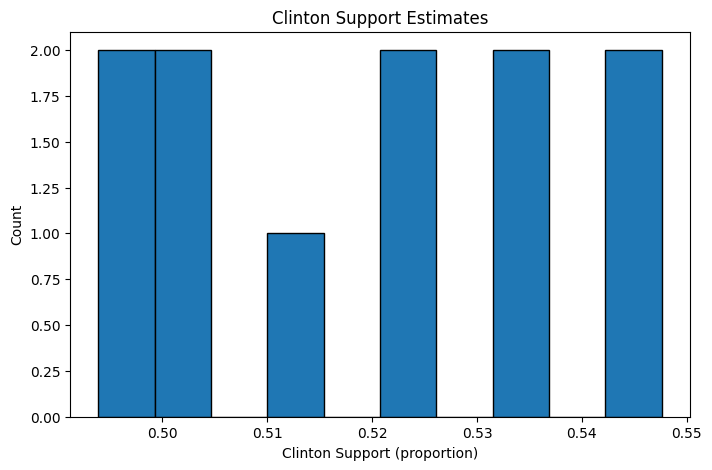

                      Method  Clinton_Estimate
 Weighted by party+education          0.493899
       Weighted by party+age          0.498809
      Weighted by party+race          0.501547
    Weighted by party+gender          0.502847
  Weighted by race+education          0.514566
        Weighted by age+race          0.523955
   Weighted by age+education          0.525594
      Weighted by gender+age          0.533309
     Weighted by gender+race          0.534440
                         Raw          0.545833
Weighted by gender+education          0.547619

Recommended single estimate (median across methods): 0.524


In [17]:
import pandas as pd
import matplotlib.pyplot as plt

def clinton_share_from_series(s):
    total = s.sum()
    return float(s.get("Hillary Clinton", 0) / total) if total > 0 else None

estimates = {}

raw = dfvote["candidate"].value_counts(normalize=True)
estimates["Raw"] = clinton_share_from_series(raw)

for demo in ["age", "gender", "party", "race", "education"]:
    pop = dfdemographic[
        (dfdemographic["Demographic_Type_1"] == demo) &
        (dfdemographic["Demographic_Type_2"].isna() | (dfdemographic["Demographic_Type_2"] == ""))
    ][["Demographic_1", "Electoral_Proportion"]].rename(columns={"Demographic_1": demo})
    if pop.empty or demo not in dfvote.columns:
        continue

    num = dfvote.groupby([demo, "candidate"]).size().rename("num").reset_index()
    den = dfvote.groupby(demo).size().rename("den").reset_index()
    tmp = num.merge(den, on=demo, how="left")
    tmp = tmp[tmp["den"] > 0]
    if tmp.empty:
        continue

    tmp = tmp.merge(pop, on=demo, how="left").rename(columns={"Electoral_Proportion": "weight"})
    tmp["weight"] = tmp["weight"].fillna(0)
    tmp["prop"] = tmp["num"] / tmp["den"]
    tmp["weighted_prop"] = tmp["prop"] * tmp["weight"]

    res = tmp.groupby("candidate")["weighted_prop"].sum()
    estimates[f"Weighted by {demo}"] = clinton_share_from_series(res)

pairs = (dfdemographic[dfdemographic["Demographic_Type_2"].notna() &
                       (dfdemographic["Demographic_Type_2"] != "")]
         [["Demographic_Type_1", "Demographic_Type_2"]].drop_duplicates())

for _, r in pairs.iterrows():
    d1, d2 = r["Demographic_Type_1"], r["Demographic_Type_2"]
    if (d1 not in dfvote.columns) or (d2 not in dfvote.columns):
        continue

    pop_joint = dfdemographic[(dfdemographic["Demographic_Type_1"] == d1) &
                              (dfdemographic["Demographic_Type_2"] == d2)]
    pop_dict = dict(zip(zip(pop_joint["Demographic_1"], pop_joint["Demographic_2"]),
                        pop_joint["Electoral_Proportion"]))
    if not pop_dict:
        continue

    num = dfvote.groupby([d1, d2, "candidate"]).size().rename("num").reset_index()
    den = dfvote.groupby([d1, d2]).size().rename("den").reset_index()
    tmp = num.merge(den, on=[d1, d2], how="left")
    tmp = tmp[tmp["den"] > 0]
    if tmp.empty:
        continue

    tmp["weight"] = tmp.apply(lambda x: pop_dict.get((x[d1], x[d2]), 0), axis=1)
    tmp["prop"] = tmp["num"] / tmp["den"]
    tmp["weighted_prop"] = tmp["prop"] * tmp["weight"]

    res = tmp.groupby("candidate")["weighted_prop"].sum()
    estimates[f"Weighted by {d1}+{d2}"] = clinton_share_from_series(res)

vals = [v for v in estimates.values() if v is not None]
plt.figure(figsize=(8, 5))
plt.hist(vals, bins=min(10, max(3, len(vals))), edgecolor="black")
plt.xlabel("Clinton Support (proportion)")
plt.ylabel("Count")
plt.title("Clinton Support Estimates")
plt.show()

summary = pd.DataFrame(
    {"Method": list(estimates.keys()), "Clinton_Estimate": list(estimates.values())}
).sort_values("Clinton_Estimate")
print(summary.to_string(index=False))

recommended = pd.Series(vals).median() if len(vals) > 0 else None
print("\nRecommended single estimate (median across methods):",
      None if recommended is None else round(float(recommended), 3))

<font color='green'> Given all your above analysis, if you were a pollster what would you report as your single estimate? 

Clinton leads Trump in Florida with about ~52.4% to ~47.6% support, based on the median of multiple weighted estimates.

<font color='green'> Justify your choice, in at most 3 sentences

I chose the median across all weighting methods because it smooths out the variability between different approaches and avoids over-reliance on any single adjustment. The median consistently points to Clinton at around 53%, aligning with the general direction of every method. While this choice reduces sensitivity to outliers, I still acknowledge that unmeasured biases and non-response could make the true margin narrower.

<font color='green'> Though we did not discuss how to calculate margin of error or standard errors with weighting in this course, what would you say if someone asked you how confident you are in your estimate? You may either qualitatively answer, or try to come up with a margin of error.  

I would say I am only moderately confident in the estimate. The different weighting methods all point to Clinton leading, which gives me some reassurance, but there are still risks from people who refused to answer or from groups not well captured in the poll. If I had to give a rough margin of error, I’d say around plus/minus 3–5 percentage points, which is typical for polls of this size.